In [1]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from sklearn.model_selection import train_test_split

import tqdm

import warnings

In [2]:
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

In [3]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [4]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Data Loading

In [5]:
trx_df = read_txn_data(use_load=False)
trx_df = preprocess_txn_data(trx_df, freq='10min')
trx_df['log_deseasoned_total_volume'] = np.log(trx_df['deseasoned_total_volume'] + 1e-07)

lob_df = create_lob_dataset(use_load=False)

df_merged = merge_txn_and_lob(trx_df, lob_df)
df_merged.head()

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
581,2018-06-04 22:00:05+00:00,9.230446,4.397665,226.0,40.0,4.832781,186.0,13.628111,53.356600,0.255416,-1.364863,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
582,2018-06-04 22:10:05+00:00,1.514159,10.978610,64.0,46.0,9.464451,18.0,12.492769,51.381314,0.243138,-1.414124,2692.780308,586348.160153,1703.077347,2692.780308,2692.780308,3.398417,122.784273,230.739393,4.72,583655.379845,1699.678930,2569.996035,2462.040915
583,2018-06-04 22:20:05+00:00,13.912035,7.559952,155.0,44.0,6.352083,111.0,21.471987,46.693972,0.459845,-0.776866,2691.271950,586392.169434,1659.315612,2691.271950,2691.271950,40.175665,134.230252,283.772371,0.39,583700.897483,1619.139947,2557.041699,2407.499579
584,2018-06-04 22:30:05+00:00,33.458906,24.673941,118.0,55.0,8.784966,63.0,58.132847,48.234130,1.205222,0.186664,2706.984033,586384.699336,1670.868923,2706.984033,2706.984033,41.243794,136.935324,278.141233,7.00,583677.715303,1629.625129,2570.048709,2428.842799
585,2018-06-04 22:40:05+00:00,4.231589,4.030567,63.0,22.0,0.201022,41.0,8.262156,49.780591,0.165971,-1.795939,2702.881834,586374.013097,1677.621445,2702.881834,2702.881834,32.417760,108.261967,266.431469,5.25,583671.131263,1645.203685,2594.619866,2436.450365


In [6]:
train_size = int(0.8 * trx_df.shape[0])
trx_df_train, trx_df_test = trx_df.iloc[:train_size], trx_df.iloc[train_size:]

# trx_df_train['time'] = trx_df_train['datetime'].dt.time
# Step 2: Extract time of day (minute-level resolution)
trx_df_train['time_of_day'] = trx_df_train['datetime'].dt.strftime('%H:%M')
trx_df_test['time_of_day'] = trx_df_test['datetime'].dt.strftime('%H:%M')

# Step 3: Compute mean volume per time_of_day from training data
mean_volume_per_minute = trx_df_train.groupby('time_of_day')['total_volume'].mean().to_dict()

# Step 4: Map mean volume to train and test
trx_df_train['mean_volume'] = trx_df_train['time_of_day'].map(mean_volume_per_minute)
trx_df_test['mean_volume'] = trx_df_test['time_of_day'].map(mean_volume_per_minute)

trx_df_train['deseasoned_total_volume'] = trx_df_train['total_volume'] / trx_df_train['mean_volume']
trx_df_test['deseasoned_total_volume'] = trx_df_test['total_volume'] / trx_df_test['mean_volume']

trx_df_train['log_deseasoned_total_volume'] = np.log(trx_df_train['deseasoned_total_volume'] + 1e-7)
trx_df_test['log_deseasoned_total_volume'] = np.log(trx_df_test['deseasoned_total_volume'] + 1e-7)

trx_df_train.drop(['time_of_day'], axis=1, inplace=True)
trx_df_test.drop(['time_of_day'], axis=1, inplace=True)

In [ ]:
trx_df_train.loc[5819:5823]

,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume
5819,2018-06-04 22:00:05+00:00,0.059804,0.730357,5.0,10.0,0.670553,5.0,0.790162,4.159836,0.189950,-1.660993
5820,2018-06-04 22:01:05+00:00,0.089359,0.849477,3.0,4.0,0.760118,1.0,0.938836,4.120465,0.227847,-1.479080
5821,2018-06-04 22:02:05+00:00,0.313458,0.508952,2.0,4.0,0.195494,2.0,0.822410,3.618109,0.227304,-1.481467
5822,2018-06-04 22:03:05+00:00,0.000992,0.199219,1.0,4.0,0.198227,3.0,0.200211,4.720850,0.042410,-3.160370
5823,2018-06-04 22:04:05+00:00,0.172042,0.000000,7.0,0.0,0.172042,7.0,0.172042,6.621891,0.025981,-3.650392


### ARMA-GARCH

In [ ]:
# start = time.time()
# best_model = pmdarima.auto_arima(train_data['Price'],                                    
#                                  seasonal=False, stationary=False, 
#                                  m=7, information_criterion='aic', 
#                                  max_order=20,                                     
#                                  max_p=10, max_d=2, max_q=10,                                     
#                                  max_P=10, max_D=2, max_Q=10,                                   
#                                  error_action='ignore')
# print("best model --> (p, d, q):", best_model.order)
# elapsed_time = time.time() - start
# print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

In [7]:
# Ensure the column is a series and drop missing values

# Runs 4 hours

series = trx_df['log_deseasoned_total_volume'].dropna()

# Split data into 80% train, 20% test
train_size = int(0.8 * len(series))
train, test = series[:train_size], series[train_size:]

# Step 1: Search for the best (p, q) based on AIC
def find_best_arma(train_series, p_range=(0, 5), q_range=(0, 5)):
    best_aic = np.inf
    best_order = None
    aic_dict = {}
    for p, q in tqdm.tqdm(product(range(p_range[0], p_range[1] + 1), range(q_range[0], q_range[1] + 1)), total=len(range(p_range[0], p_range[1] + 1)) * len(range(q_range[0], q_range[1] + 1))):
        if p == 0 and q == 0:
            continue  # Skip ARMA(0,0)
        try:
            model = ARIMA(train_series, order=(p, 0, q))
            result = model.fit()
            aic_dict[(p, q)] = result.aic
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, q)
        except:
            continue  # Skip models that fail to converge
    return aic_dict, best_order

aic_dict, best_order = find_best_arma(train, (0, 8), (0, 8))
best_p, best_q = best_order
print(f"Optimal ARMA order: ({best_p}, {best_q})")



  0%|          | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [26:21<00:00, 19.53s/it]

Optimal ARMA order: (3, 7)


In [9]:
for key, value in aic_dict.items():
    if value < aic_dict[(3,7)]+2:
        print(key, value)

(3, 7) 39177.16914499156
(3, 8) 39179.07684171946
(4, 7) 39178.49731199207
(6, 4) 39178.43625302179
(8, 3) 39177.99083177115


In [10]:
train, test = trx_df_train['log_deseasoned_total_volume'], trx_df_test['log_deseasoned_total_volume']

best_p, best_q = 3, 7

# Step 2: Fit ARMA-GARCH(1,1) model on train set
arma_model = ARIMA(train, order=(best_p, 0, best_q)).fit(method_kwargs={"solver": "lbfgs", "maxiter": 500})
residuals = arma_model.resid  # Get ARMA residuals

In [11]:
print(arma_model.summary())

                                    SARIMAX Results                                    
Dep. Variable:     log_deseasoned_total_volume   No. Observations:                14059
Model:                          ARIMA(3, 0, 7)   Log Likelihood              -19567.615
Date:                         Thu, 15 May 2025   AIC                          39159.231
Time:                                 23:13:28   BIC                          39249.843
Sample:                                      0   HQIC                         39189.390
                                       - 14059                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7219      0.131     -5.515      0.000      -0.978      -0.465
ar.L1         -0.0484      0.090     -0.539      0.590     

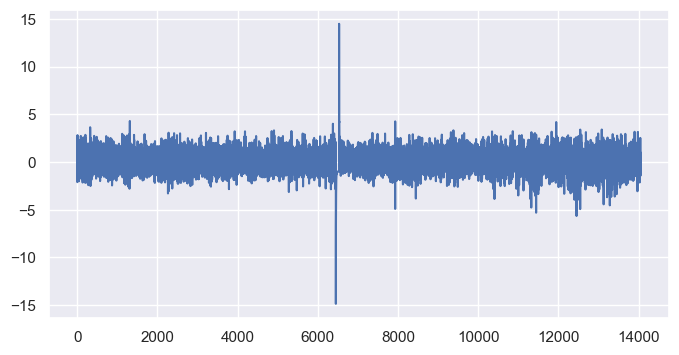

In [12]:
plt.plot(residuals)

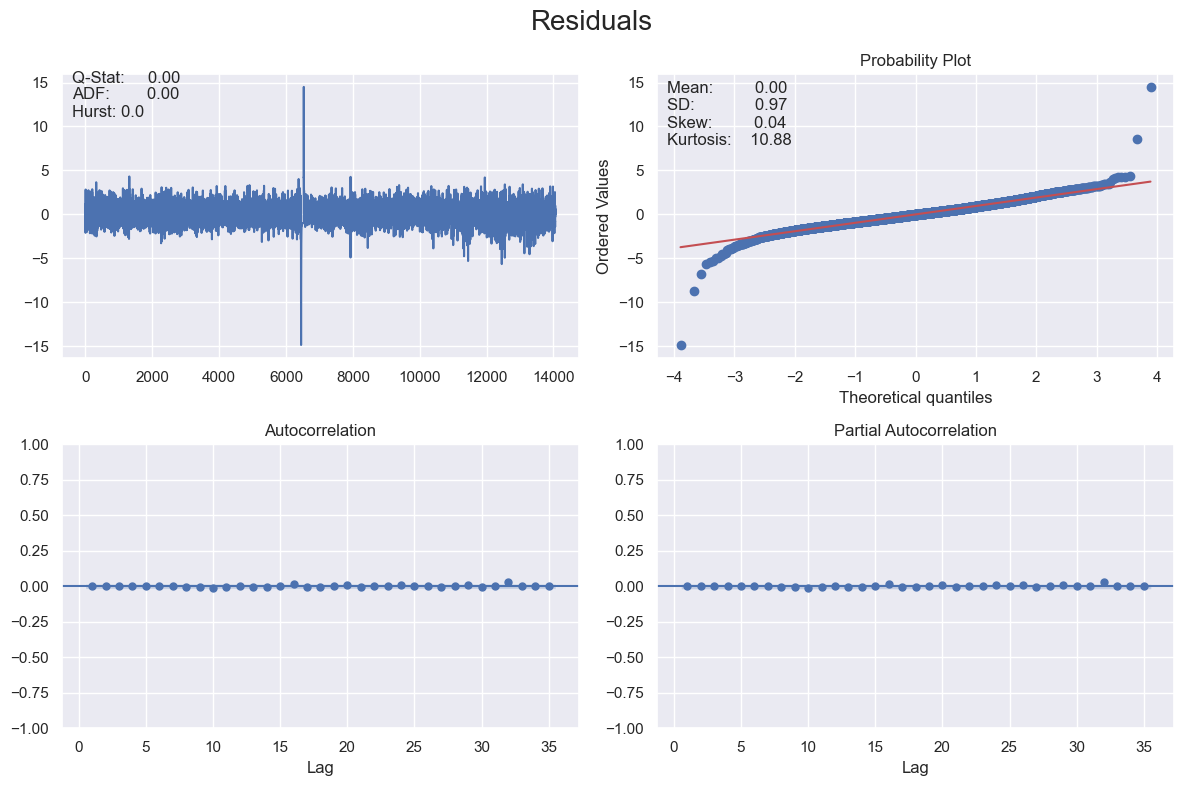

In [13]:
# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(residuals, lags=35, title='Residuals')

In [14]:
garch_model = arch_model(residuals, vol="Garch", p=1, q=1, mean="zero")
garch_result = garch_model.fit(options={"maxiter": 500})#disp="off", 


Iteration:      1,   Func. Count:      5,   Neg. LLF: 88837.23961858034
Iteration:      2,   Func. Count:     13,   Neg. LLF: 19645.22627017609
Iteration:      3,   Func. Count:     20,   Neg. LLF: 19194.574883638263
Iteration:      4,   Func. Count:     25,   Neg. LLF: 19195.23610216907
Iteration:      5,   Func. Count:     30,   Neg. LLF: 39001.22352068279
Iteration:      6,   Func. Count:     35,   Neg. LLF: 19151.666198073857
Iteration:      7,   Func. Count:     39,   Neg. LLF: 19656.648951921317
Iteration:      8,   Func. Count:     45,   Neg. LLF: 7683826613.261612
Iteration:      9,   Func. Count:     52,   Neg. LLF: 31037.535832785645
Iteration:     10,   Func. Count:     59,   Neg. LLF: 19191.77451289603
Iteration:     11,   Func. Count:     64,   Neg. LLF: 19560.551707053964
Iteration:     12,   Func. Count:     70,   Neg. LLF: 19179.477242677185
Iteration:     13,   Func. Count:     75,   Neg. LLF: 19148.539871644723
Iteration:     14,   Func. Count:     79,   Neg. LLF: 191

In [15]:
print(garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -19148.5
Distribution:                  Normal   AIC:                           38303.1
Method:            Maximum Likelihood   BIC:                           38325.7
                                        No. Observations:                14059
Date:                Thu, May 15 2025   Df Residuals:                    14059
Time:                        23:14:03   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.1616e-03  7.643e-03      1.199      0.231 

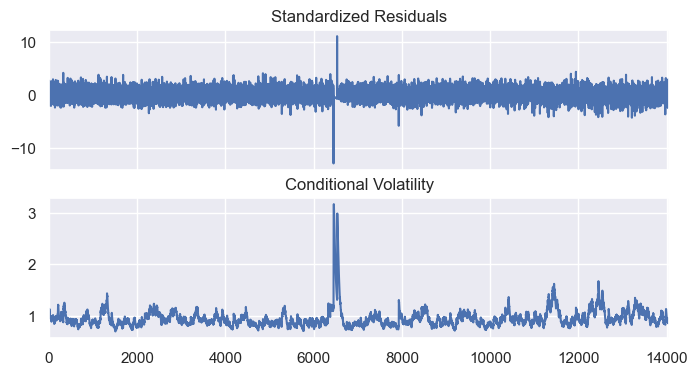

In [16]:
# Plot fitted results
garch_result.plot()
plt.show()

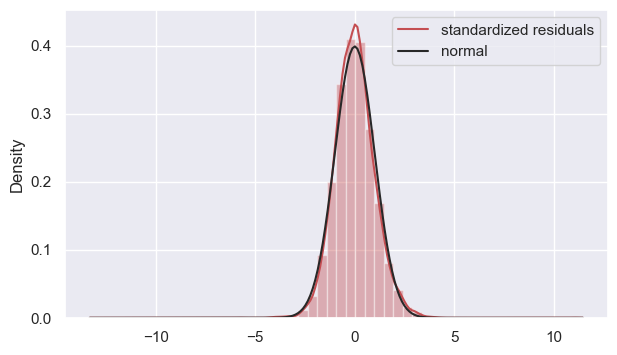

In [17]:
# Obtain model estimated residuals and volatility
gm_resid = garch_result.resid
gm_std = garch_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('standardized residuals', 'normal'))
plt.show()

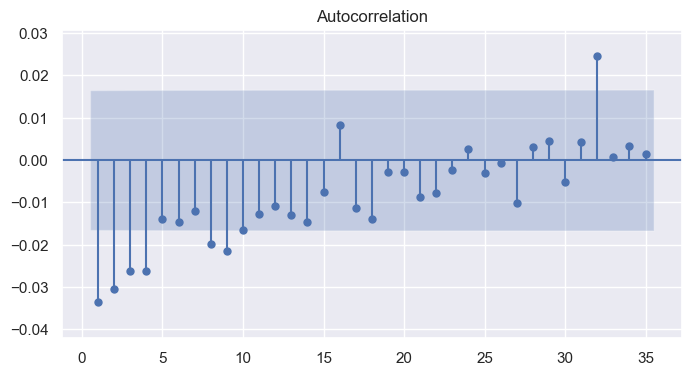

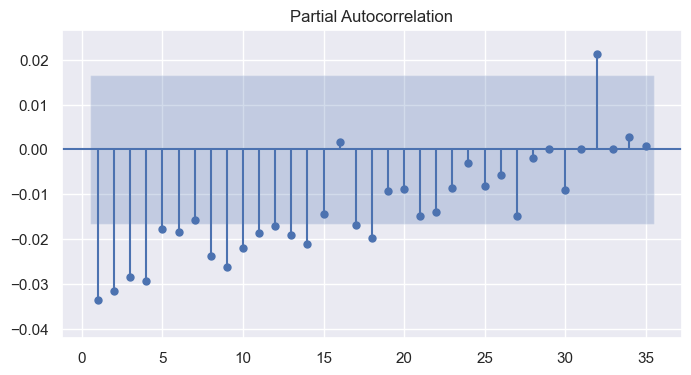

In [18]:
plot_acf(gm_std_resid, lags=35, zero=False, auto_ylims=True);
plot_pacf(gm_std_resid, lags=35, zero=False, auto_ylims=True);

### Prediction

In [19]:
print(garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -19148.5
Distribution:                  Normal   AIC:                           38303.1
Method:            Maximum Likelihood   BIC:                           38325.7
                                        No. Observations:                14059
Date:                Thu, May 15 2025   Df Residuals:                    14059
Time:                        23:14:03   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.1616e-03  7.643e-03      1.199      0.231 

In [20]:
print(arma_model.summary())

                                    SARIMAX Results                                    
Dep. Variable:     log_deseasoned_total_volume   No. Observations:                14059
Model:                          ARIMA(3, 0, 7)   Log Likelihood              -19567.615
Date:                         Thu, 15 May 2025   AIC                          39159.231
Time:                                 23:14:46   BIC                          39249.843
Sample:                                      0   HQIC                         39189.390
                                       - 14059                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7219      0.131     -5.515      0.000      -0.978      -0.465
ar.L1         -0.0484      0.090     -0.539      0.590     

In [ ]:
for index, value in zip(arma_model.params.index, arma_model.params):
    print(index, value)

const -0.8926866459750243
ar.L1 1.2553742212954424
ar.L2 -0.19553194006406388
ar.L3 -0.021951923107966974
ar.L4 -0.018452943576259463
ar.L5 -0.002876761578212643
ar.L6 -0.02142244168551119
ma.L1 -0.9080302861767019
sigma2 1.2947787043448586


In [ ]:
garch_result.params

omega       0.029124
alpha[1]    0.044803
beta[1]     0.932692
Name: params, dtype: float64

![image.png](attachment:image.png)

In [21]:
def construct_1step_ARMA_pred(returns, resids, coefs):
    ar_part = 0
    ma_part = 0

    for index, coef in zip(coefs.index, coefs):
        if 'ma.L' in index:
            lag = int(index.split('ma.L')[-1])
            ma_part += resids[-lag]*coef
        
        elif 'ar.L' in index:
            lag = int(index.split('ar.L')[-1])
            ar_part += returns[-lag]*coef

    return coefs['const'] + ma_part + ar_part

def construct_1step_GARCH_pred(resid, volatility, coefs):
    return np.sqrt(coefs["omega"] + coefs["alpha[1]"]*np.square(resid) + coefs["beta[1]"]*np.square(volatility))


returns_lagged = list(arma_model.fittedvalues[-3:].values)
resids_lagged = list(arma_model.resid[-7:].values)

resid_last, volat_last = garch_result.resid.values[-1], garch_result.conditional_volatility.values[-1]

preds = []
volatility_preds = []
resids = []

for test_value in tqdm.tqdm(test.values):
    pred = construct_1step_ARMA_pred(returns_lagged, resids_lagged, arma_model.params)
    preds.append(pred)
    returns_lagged = returns_lagged[1:] + [test_value]
    resids_lagged = resids_lagged[1:] + [test_value - pred]

    vol_pred = construct_1step_GARCH_pred(resid_last, volat_last, garch_result.params)
    volatility_preds.append(vol_pred)

    resid_last = test_value - pred
    resids.append(resid_last)
    volat_last = vol_pred

100%|██████████| 3515/3515 [00:00<00:00, 4512.84it/s]


In [22]:
trx_df_train['log_deseasonalized_preds'] = list(arma_model.fittedvalues)
trx_df_train['deseasonalized_preds'] = np.exp(trx_df_train['log_deseasonalized_preds'])
trx_df_train['preds'] = trx_df_train['deseasonalized_preds'] * trx_df_train['mean_volume']

trx_df_train['predicted_volatility'] = list(garch_result.conditional_volatility)
trx_df_train['resids_'] = list(garch_result.resid)


trx_df_test['log_deseasonalized_preds'] = preds
trx_df_test['deseasonalized_preds'] = np.exp(trx_df_test['log_deseasonalized_preds'])
trx_df_test['preds'] = trx_df_test['deseasonalized_preds'] * trx_df_test['mean_volume']

trx_df_test['predicted_volatility'] = volatility_preds
trx_df_test['resids_'] = resids


In [23]:
trx_df_test.tail()

,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,log_deseasonalized_preds,deseasonalized_preds,preds,predicted_volatility,resids_
17569,2018-09-30 21:20:05+00:00,6.809888,9.693232,53.0,38.0,2.883344,15.0,16.503121,101.535522,0.162535,-1.816859,-2.078868,0.125072,12.699221,1.286192,0.262009
17570,2018-09-30 21:30:05+00:00,2.239655,5.038138,24.0,29.0,2.798484,5.0,7.277793,98.672527,0.073757,-2.606978,-2.244157,0.106017,10.460949,1.267964,-0.362820
17571,2018-09-30 21:40:05+00:00,19.195661,0.440945,67.0,6.0,18.754716,61.0,19.636605,73.443911,0.267369,-1.319126,-2.722515,0.065709,4.825947,1.250749,1.403389
17572,2018-09-30 21:50:05+00:00,4.070999,1.943877,29.0,13.0,2.127122,16.0,6.014876,55.749085,0.107892,-2.226624,-2.381077,0.092451,5.154057,1.252432,0.154452
17573,2018-09-30 22:00:05+00:00,9.546455,3.032429,60.0,21.0,6.514026,39.0,12.578884,55.933034,0.224892,-1.492135,-2.605163,0.073891,4.132954,1.234456,1.113027


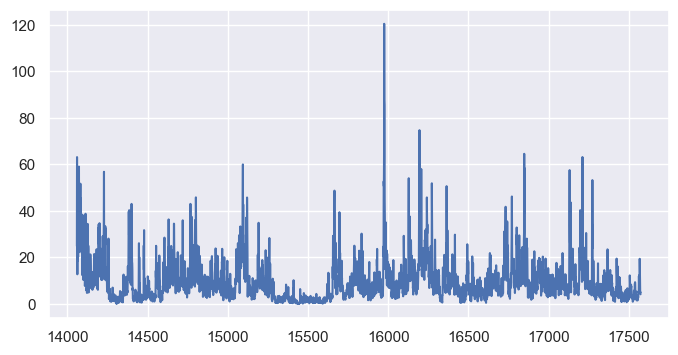

In [24]:
plt.plot(trx_df_test["preds"])

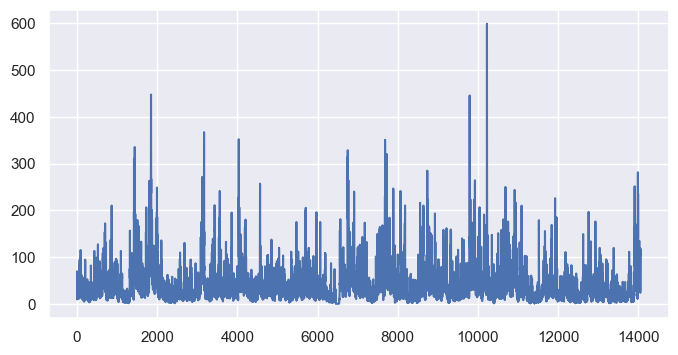

In [25]:
plt.plot(trx_df_train["preds"])

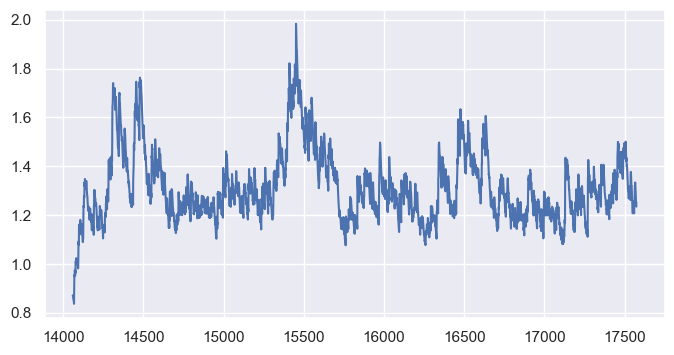

In [26]:
plt.plot(trx_df_test["predicted_volatility"])

In [ ]:
trx_df_test.head()

,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,log_deseasonalized_preds,deseasonalized_preds,preds,predicted_volatility,resids_
140592,2018-09-06 12:13:05+00:00,0.010827,0.000000,1.0,0.0,0.010827,1.0,0.010827,8.069099,0.001342,-6.613651,-7.146490,0.000788,0.006355,1.752315,0.532839
140593,2018-09-06 12:14:05+00:00,1.139073,32.505673,3.0,4.0,31.366600,1.0,33.644746,6.600579,5.097242,1.628700,4.027397,56.114633,370.389065,1.736455,-2.398697
140594,2018-09-06 12:15:05+00:00,10.533393,0.516823,5.0,4.0,10.016569,1.0,11.050216,6.153717,1.795698,0.585394,-8.716775,0.000164,0.001008,1.756430,9.302169
140595,2018-09-06 12:16:05+00:00,0.039058,0.165731,1.0,2.0,0.126672,1.0,0.204789,6.763277,0.030280,-3.497279,0.405574,1.500163,10.146021,2.231848,-3.902853
140596,2018-09-06 12:17:05+00:00,0.100000,0.153261,1.0,3.0,0.053261,2.0,0.253261,6.367618,0.039773,-3.224557,-6.091036,0.002263,0.014410,2.284450,2.866479


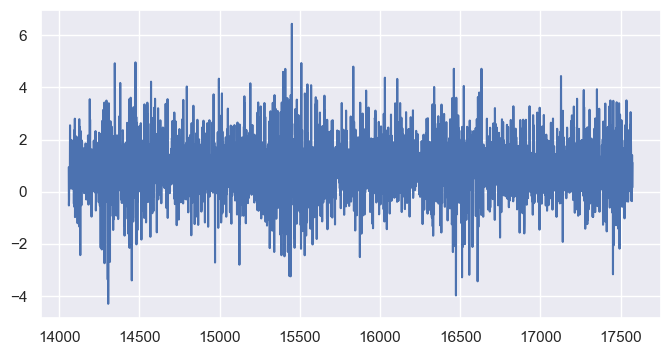

In [27]:
plt.plot(trx_df_test["resids_"])

In [28]:
y_test, y_test_pred = trx_df_test.loc[train_size:, "total_volume"].values, trx_df_test.loc[train_size:, "preds"].values

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have y_test and y_test_pred as arrays or Series

# MAE
mae = mean_absolute_error(y_test, y_test_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 27.8271
RMSE: 62.3391
